# Проект: "Выбор локации для скважины"

**Описание проекта:**

Вы работаете в добывающей компании **«ГлавРосГосНефть»**. Нужно решить, где бурить новую скважину. 

Шаги для выбора локации обычно такие:
1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе также уже известны. 

**Цель проекта:**
1. Построить модель для определения региона, где добыча принесёт наибольшую прибыль.
2. Проанализировать возможную прибыль и риски техникой Bootstrap.

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия **(остальные — недостаточно предсказуемые)**.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд. рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Описание данных:**

Данные геологоразведки трёх регионов находятся в следующих файлах: *'/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv'.* 

Для них:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**План работы с проектом:**
1. Загрузка и изучение данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Проведение корреляционного анализа данных;
5. Обучение и проверка модели;
6. Подготовка к расчету прибыли;
7. Расчет прибыли и рисков;
8. Формирование итоговых выводов.

## Загрузка и изучение данных

In [1]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import math
import sklearn
import numpy as np
from scipy import stats as st

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузим модули, необходимые для работы
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# введение констант
RANDOM_STATE = 42
N = 500 # количество исследуемых точек
K = 200 # количество точек для разработки
BUDGET = 10000000000 # бюджет на разработку скважин в регионе
BAR_COST = 450000 # доход с 1000 баррелей

### Загрузка и изучение данных файла "geo_data_0.csv"

In [3]:
# загрузим данные из файла 'geo_data_0.csv'
try:
    # локальный путь к файлу
    data_0 = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/МО_в_бизнесе/geo_data_0.csv')
except:
    # путь к файлу в тренажере
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')

# посмотрим первые 5 строк датафрема
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# посмотрим общую информацию о данных
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# посмотрим описательную статистику данных
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, типы данных в столбцах корректные. Пропуски в данных отсутствуют.

### Загрузка и изучение данных файла "geo_data_1.csv"

In [6]:
# загрузим данные из файла 'geo_data_1.csv'
try:
    # локальный путь к файлу
    data_1 = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/МО_в_бизнесе/geo_data_1.csv')
except:
    # путь к файлу в тренажере
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')

# посмотрим первые 5 строк датафрема
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
# посмотрим общую информацию о данных
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# посмотрим описательную статистику данных
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, типы данных в столбцах корректные. Пропуски в данных отсутствуют.

### Загрузка и изучение данных файла "geo_data_2.csv"

In [9]:
# загрузим данные из файла 'geo_data_2.csv'
try:
    # локальный путь к файлу
    data_2 = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/МО_в_бизнесе/geo_data_2.csv')
except:
    # путь к файлу в тренажере
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')

# посмотрим первые 5 строк датафрема
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [10]:
# посмотрим общую информацию о данных
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
# посмотрим описательную статистику данных
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Примечание:** По полученным результатам видно, что данные соответствуют описанию задачи, типы данных в столбцах корректные. Пропуски в данных отсутствуют.

**Обобщающий вывод этапа "Загрузка и изучение данных":** 
1. Данные во всех таблицах соответсвуют описанию задачи.
2. Пропуски во всех таблицах отсутствуют.
3. Типы данных для столбцов каждой из таблиц корректные.

## Предобработка данных

### Предобработка данных в таблице "data_0"

In [12]:
# посмотрим количество пропусков в данных
data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Примечание:** Как и было замечено ранее, пропуски в данных отсутствуют.

In [13]:
# проверим датафрейм на наличие явных дубликатов
data_0.duplicated().sum()

0

**Примечание:** Явные дубликаты в данных отсутствуют.

In [14]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
data_0.duplicated(subset='id').sum()

10

In [15]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
dupl_data_0 = data_0[data_0.duplicated(subset='id', keep=False)]  # keep=False помечает все дубликаты, включая их первое вхождение
dupl_data_0_sorted = dupl_data_0.sort_values('id')

# выведем полученные неявные дубликаты для анализа
print(f"Всего строк с дубликатами в столбце 'id': {len(dupl_data_0)}")
print("Строки с дубликатами:")
print(dupl_data_0_sorted)

Всего строк с дубликатами в столбце 'id': 20
Строки с дубликатами:
          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.

**Примечание:** Как показала проверка, явные дубликаты отсутствуют. Однако встречаются скважины с одинаковыым значением в столбце 'id', но разными значениями в других столбцах, скорее всего, это может быть связано с ошибкой присвоения уникального индентификатора скважен. Данные с одинаковыми значениями в столбце 'id' удалять не будем.

### Предобработка данных в таблице "data_1"

In [16]:
# посмотрим количество пропусков в данных
data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Примечание:** Как и было замечено ранее, пропуски в данных отсутствуют.

In [17]:
# проверим датафрейм на наличие явных дубликатов
data_1.duplicated().sum()

0

**Примечание:** Явные дубликаты в данных отсутствуют.

In [18]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
data_1.duplicated(subset='id').sum()

4

In [19]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
dupl_data_1 = data_1[data_1.duplicated(subset='id', keep=False)]  # keep=False помечает все дубликаты, включая их первое вхождение
dupl_data_1_sorted = dupl_data_1.sort_values('id')

# выведем полученные неявные дубликаты для анализа
print(f"Всего строк с дубликатами в столбце 'id': {len(dupl_data_1)}")
print("Строки с дубликатами:")
print(dupl_data_1_sorted)

Всего строк с дубликатами в столбце 'id': 8
Строки с дубликатами:
          id         f0         f1        f2     product
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305


**Примечание:** Как показала проверка, явные дубликаты отсутствуют. Однако встречаются скважины с одинаковыым значением в столбце 'id', но разными значениями в других столбцах, скорее всего, это может быть связано с ошибкой присвоения уникального индентификатора скважен. Данные с одинаковыми значениями в столбце 'id' удалять не будем.

### Предобработка данных в таблице "data_2"

In [20]:
# посмотрим количество пропусков в данных
data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Примечание:** Как и было замечено ранее, пропуски в данных отсутствуют.

In [21]:
# проверим датафрейм на наличие явных дубликатов
data_2.duplicated().sum()

0

**Примечание:** Явные дубликаты в данных отсутствуют.

In [22]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
data_2.duplicated(subset='id').sum()

4

In [23]:
# проверим датафрейм на наличие неявных дубликатов
# проверка будет проводиться по столбцу 'id'
dupl_data_2 = data_2[data_2.duplicated(subset='id', keep=False)]  # keep=False помечает все дубликаты, включая их первое вхождение
dupl_data_2_sorted = dupl_data_2.sort_values('id')

# выведем полученные неявные дубликаты для анализа
print(f"Всего строк с дубликатами в столбце 'id': {len(dupl_data_2)}")
print("Строки с дубликатами:")
print(dupl_data_2_sorted)

Всего строк с дубликатами в столбце 'id': 8
Строки с дубликатами:
          id        f0        f1        f2     product
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641


**Примечание:** Как показала проверка, явные дубликаты отсутствуют. Однако встречаются скважины с одинаковыым значением в столбце 'id', но разными значениями в других столбцах, скорее всего, это может быть связано с ошибкой присвоения уникального индентификатора скважен. Данные с одинаковыми значениями в столбце 'id' удалять не будем.

**Обобщающий вывод этапа "Предобработка данных":**
1. Во всех таблицах отсутствуют пропуски.
2. В таблицах отсутствуют явные и неявные дубликаты.
3. Во всех таблицах встречаются скважины с одинаковыым значением в столбце 'id', но разными значениями в других столбцах, скорее всего, это может быть связано **с ошибкой присвоения уникального индентификатора скважен**. Данные с одинаковыми значениями в столбце 'id' удалять не будем.

## Исследовательский анализ данных

### Исследовательский анализ данных таблицы 'data_0'

In [24]:
# проведем статистический анализ всех признаков в таблице 'data_0'
# все столбцы, кроме столбца 'id', имеют количественные значения
print('Описательная статистика для количественных признаков:')
data_0.describe(include=[np.number])

Описательная статистика для количественных признаков:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [25]:
# напишем собственную функцию для визуализации всех количественных признаков на одном графике
def plot_histograms(data, title):
    # устанавливаем параметры графика
    plt.figure(figsize=(12, 8))
    
    # строим гистограммы для каждого признака
    axes = data.iloc[:, 1:].hist(
        figsize=(12, 8),
        bins=30,
        color='steelblue',
        edgecolor='white',
        grid=False, 
        layout=(2, 2), 
)
    
    # окончательно настраиваем график
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

<Figure size 864x576 with 0 Axes>

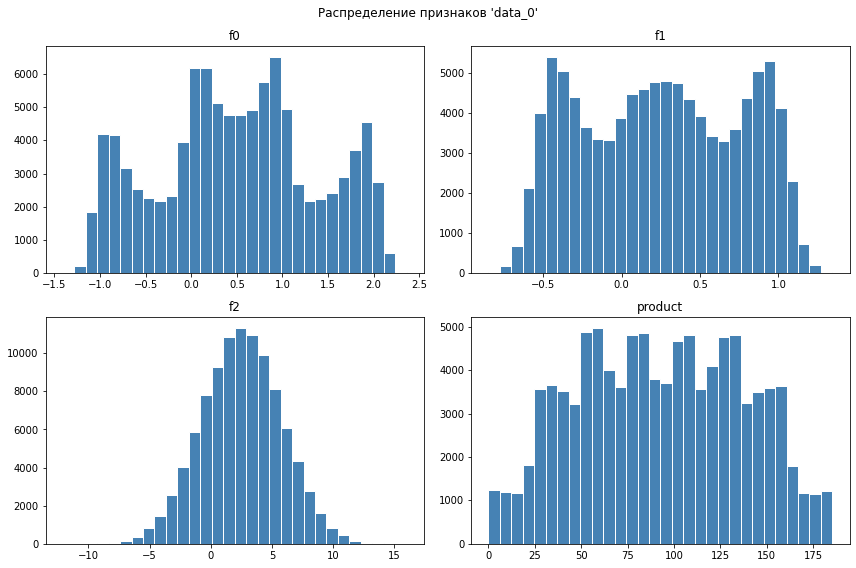

In [26]:
# визуализируем количественные признаки таблицы 'data_0'
plot_histograms(data_0, "Распределение признаков 'data_0'")

In [27]:
# напишем собственную функцию для построения графика "Ящик с усами" для всех количественных признаков
# устанавливаем параметры графика
def plot_boxplots(data, title):
    # устанавливаем параметры графика
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # строим график для первых трех признаков
    sns.boxplot(data=data.iloc[:,1:4], ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels())
    ax1.set_title("График 'Ящик с усами' для признаков 'f0', 'f1', 'f2'", fontsize=10, pad=10)
    
    # строим график для признака объем запасов в скважине
    sns.boxplot(data=data.iloc[:,4:], ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels())
    ax2.set_title("График 'Ящик с усами' для признака 'product'", fontsize=10, pad=10)

    # окончательно настраиваем график
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

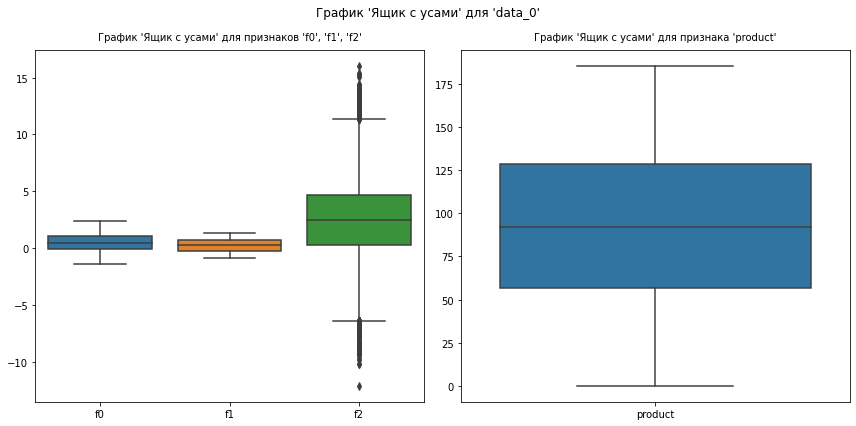

In [28]:
# визуализируем количественные признаки таблицы 'data_0'
plot_boxplots(data_0, "График 'Ящик с усами' для 'data_0'")

### Исследовательский анализ данных таблицы 'data_1'

In [29]:
# проведем статистический анализ всех признаков в таблице 'data_1'
# все столбцы, кроме столбца 'id', имеют количественные значения
print('Описательная статистика для количественных признаков:')
data_1.describe(include=[np.number])

Описательная статистика для количественных признаков:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<Figure size 864x576 with 0 Axes>

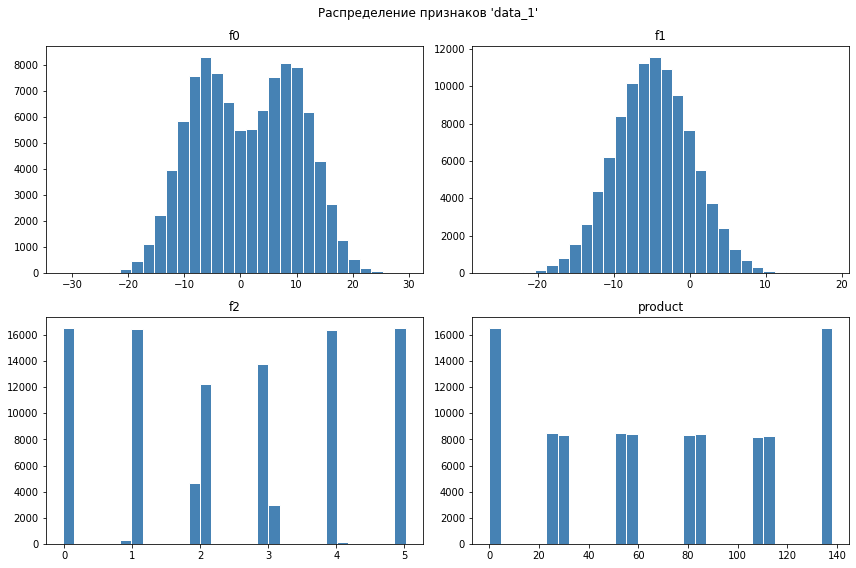

In [30]:
# визуализируем количественные признаки таблицы 'data_1'
plot_histograms(data_1, "Распределение признаков 'data_1'")

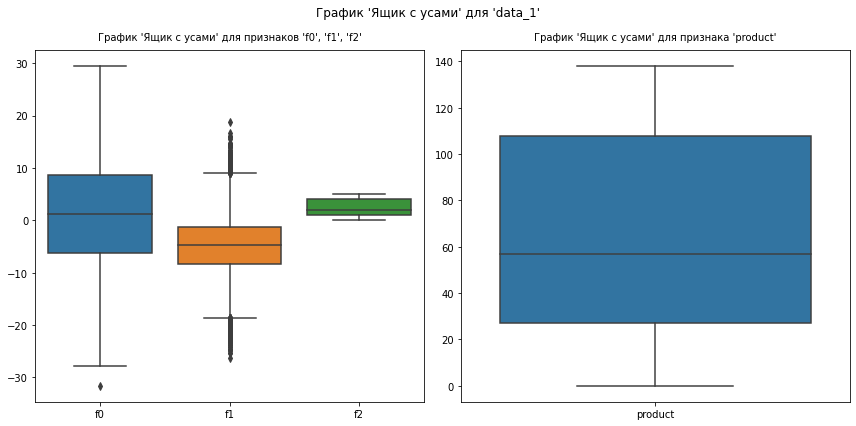

In [31]:
# визуализируем количественные признаки таблицы 'data_1'
plot_boxplots(data_1, "График 'Ящик с усами' для 'data_1'")

### Исследовательский анализ данных таблицы 'data_2'

In [32]:
# проведем статистический анализ всех признаков в таблице 'data_2'
# все столбцы, кроме столбца 'id', имеют количественные значения
print('Описательная статистика для количественных признаков:')
data_2.describe(include=[np.number])

Описательная статистика для количественных признаков:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<Figure size 864x576 with 0 Axes>

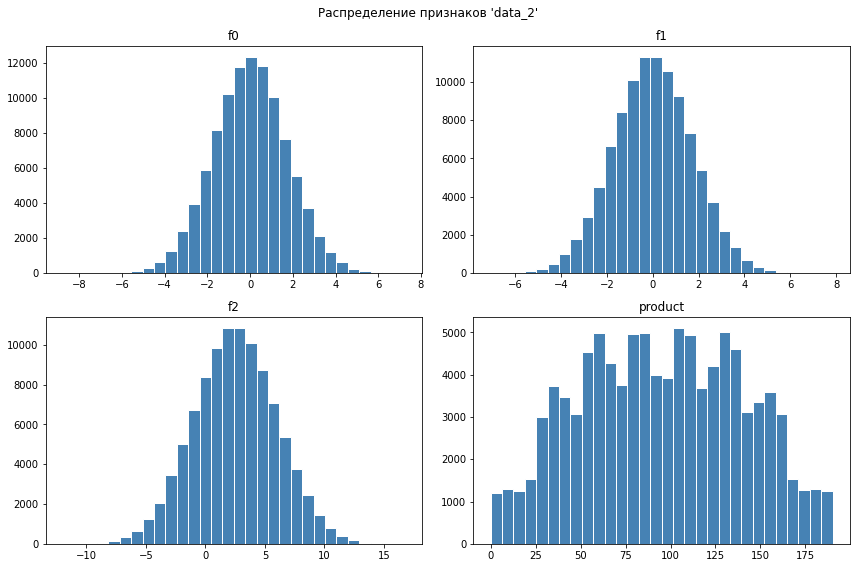

In [33]:
# визуализируем количественные признаки таблицы 'data_2'
plot_histograms(data_2, "Распределение признаков 'data_2'")

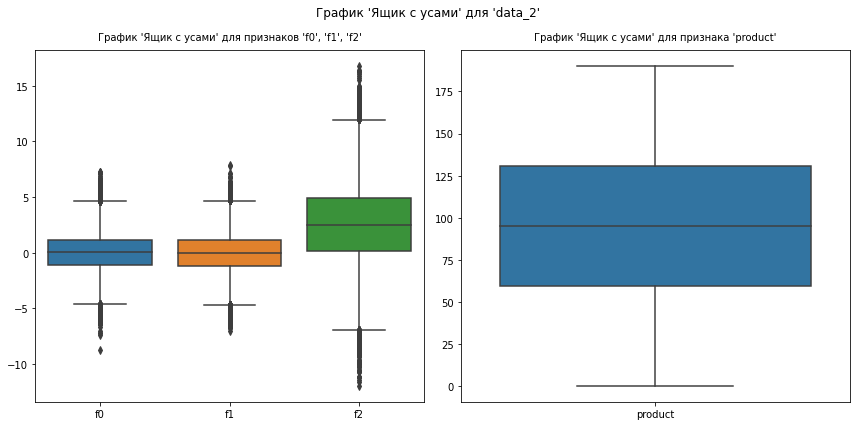

In [34]:
# визуализируем количественные признаки таблицы 'data_2'
plot_boxplots(data_2, "График 'Ящик с усами' для 'data_2'")

**Обощающий вывод этапа "Исследовательский анализ данных":**

Трудно говорить конкретно о характере распределения данных, так как почти ничего неизвестно о их природе, исходные данные **синтетические**. 

Изначальная информация такова: f0, f1, f2 — три признака точек **(неважно, что они означают, но сами признаки значимы)**;
product — объём запасов в скважине (тыс. баррелей).

Поэтому можно сказать общие сведения, которые были получены в процессе проведения исследовательского нализа данных:
1. **Для таблицы 'data_0':** Признак 'f2' имеет нормальное распределение, но при этом имеет достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Остальные признаки выбросов не имеют.
2. **Для таблицы 'data_1':** Признак 'f1' имеет нормальное распределение, но при этом имеет достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Остальные признаки выбросов не имеют.
3. **Для таблицы 'data_2':** Признаки 'f0', 'f1' и 'f2' имеют нормальное распределение, но при этом имеют достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Признак 'product' выбросов не имеет.

## Проведение корреляционного анализа данных

In [35]:
# посмотрим наличие корреляции между признаками таблицы 'data_0'
matrix_0 = data_0.drop('id', axis=1)
matrix_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [36]:
# посмотрим наличие корреляции между признаками таблицы 'data_1'
matrix_1 = data_1.drop('id', axis=1)
matrix_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [37]:
# посмотрим наличие корреляции между признаками таблицы 'data_2'
matrix_2 = data_2.drop('id', axis=1)
matrix_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Обобщающий вывод этапа "Проведение корреляционного анализа данных":**

Среди всех признаков больше всего выделяется признак 'f2', который имеет корреляцию выше остальных признаков с признаком 'product'. В таблице 'data_1' прослеживается особенно сильная корреляция между признаками 'f2' и 'product', равная 0.99.

## Обучение и проверка модели

### Разобьем данные на обучающую и валидационную выборки

In [38]:
# напишем собственную функцию для разбиения
def split_data(data):
    data_target = data['product']
    data_features = data.drop(['id', 'product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(data_features, data_target, test_size=0.25, random_state=RANDOM_STATE, shuffle = True)
    return features_train, features_valid, target_train, target_valid

In [39]:
# разбиваем все три датасета на обучающую и валидационную выборки
# для таблицы 'data_0'
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(data_0)
# для таблицы 'data_1'
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(data_1)
# для таблицы 'data_2'
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(data_2)

### Обучение модели

In [40]:
# по условиям задачи для обучения модели подходит только линейная регрессия
# напишем собственную функцию для обучения модели
def learn_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions_constant = pd.Series(target_train.mean(), index=target_valid.index)

    # расчет метрик
    rmse = mean_squared_error(target_valid, predictions) ** 0.5
    rmse_constant = mean_squared_error(target_valid, predictions_constant)**0.5
    mean_product = predictions.mean()
    return target_valid, predictions, rmse, rmse_constant, mean_product

In [41]:
def model_lr(future_train, future_valid, target_train, target_valid):
    lr.fit(future_train, target_train)
    predicted_valid = lr.predict(future_valid)
    
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    mean_sum = predicted_valid.sum()/len(predicted_valid)
    return mse, rmse, mean_sum, predicted_valid

#### Обучение модели для региона 'data_0'

In [42]:
# полученные результаты для первого региона 'data_0'
data_0_target_valid, data_0_predictions_valid, data_0_rmse, data_0_rmse_constant, data_0_mean_product = learn_model(features_train_0, features_valid_0, target_train_0, target_valid_0)

# выведем предсказания и правильные ответы на валидационной выборке
data_0_predictions_valid = pd.Series(data_0_predictions_valid, index=data_0_target_valid.index)
print(data_0_target_valid.head())
print(data_0_predictions_valid.head())

75721    122.073350
80184     48.738540
19864    131.338088
76699     88.327757
92991     36.959266
Name: product, dtype: float64
75721    101.901017
80184     78.217774
19864    115.266901
76699    105.618618
92991     97.980185
dtype: float64


In [43]:
# выведем рассчитанные метрики для 'data_0'
print(f'Регион data_0: Метрика RMSE модели составляет {data_0_rmse:.2f}, Метрика RMSE модели-константы составляет {data_0_rmse_constant:.2f}, Средний запас предсказанного сырья {data_0_mean_product:.2f}')

Регион data_0: Метрика RMSE модели составляет 37.76, Метрика RMSE модели-константы составляет 44.28, Средний запас предсказанного сырья 92.40


#### Обучение модели для региона 'data_1'

In [44]:
# полученные результаты для первого региона 'data_1'
data_1_target_valid, data_1_predictions_valid, data_1_rmse, data_1_rmse_constant, data_1_mean_product = learn_model(features_train_1, features_valid_1, target_train_1, target_valid_1)

# выведем предсказания и правильные ответы на валидационной выборке
data_1_predictions_valid = pd.Series(data_1_predictions_valid, index=data_1_target_valid.index)
print(data_1_target_valid.head())
print(data_1_predictions_valid.head())

75721      0.000000
80184     53.906522
19864    134.766305
76699    107.813044
92991      0.000000
Name: product, dtype: float64
75721      0.844738
80184     52.921612
19864    135.110385
76699    109.494863
92991     -0.047292
dtype: float64


In [45]:
# выведем рассчитанные метрики для 'data_1'
print(f'Регион data_1: Метрика RMSE модели составляет {data_1_rmse:.2f}, Метрика RMSE модели-константы составляет {data_1_rmse_constant:.2f}, Средний запас предсказанного сырья {data_1_mean_product:.2f}')

Регион data_1: Метрика RMSE модели составляет 0.89, Метрика RMSE модели-константы составляет 45.94, Средний запас предсказанного сырья 68.71


#### Обучение модели для региона 'data_2'

In [46]:
# полученные результаты для первого региона 'data_2'
data_2_target_valid, data_2_predictions_valid, data_2_rmse, data_2_rmse_constant, data_2_mean_product = learn_model(features_train_2, features_valid_2, target_train_2, target_valid_2)

# выведем предсказания и правильные ответы на валидационной выборке
data_2_predictions_valid = pd.Series(data_2_predictions_valid, index=data_2_target_valid.index)
print(data_2_target_valid.head())
print(data_2_predictions_valid.head())

75721    117.441301
80184     47.841249
19864     45.883483
76699    139.014608
92991     84.004276
Name: product, dtype: float64
75721     98.301916
80184    101.592461
19864     52.449099
76699    109.922127
92991     72.411847
dtype: float64


In [47]:
# выведем рассчитанные метрики для 'data_2'
print(f'Регион data_2: Метрика RMSE модели составляет {data_2_rmse:.2f}, Метрика RMSE модели-константы составляет {data_2_rmse_constant:.2f}, Средний запас предсказанного сырья {data_2_mean_product:.2f}')

Регион data_2: Метрика RMSE модели составляет 40.15, Метрика RMSE модели-константы составляет 44.78, Средний запас предсказанного сырья 94.77


**Обобщающий вывод этапа "обучение и проверка модели":**

Наиболее точная по предсказанию модель оказалась для региона 'data_1', метрика RMSE модели для этого региона равна 0.89, что является лучшим результатом по сравнению с другими моделями. Однако средний запас предсказанного сырья для региона 'data_1' составил 68.71, что значительно меньше по сравнению с другими регионами. Наибольший средний запас предсказанного сырья показал регион 'data_2', равный 94.77.

## Подготовка к расчету прибыли

In [48]:
# все ключевые значения для расчета прибыли сохранены в отдельных переменных в начале проекта
# рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

# рассчитаем бюджет для одной скважины
budget_well = BUDGET / K
# рассчитаем объем сырья для безубыточной разработки скважины
product_well = budget_well / BAR_COST
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {product_well:.2f} баррель.')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 баррель.


In [49]:
# сравним полученный достаточный объем сырья со средним запасом сырья в каждом регионе
# т.к. мы уже знаем, что средний запас сырья в каждом регионе меньше рассчитанного объема, то посмотрим,  насколько
print(f'Объём сырья для безубыточной разработки новой скважины в data_0: {product_well- data_0_mean_product:.2f} баррель.')
print(f'Объём сырья для безубыточной разработки новой скважины в data_1: {product_well - data_1_mean_product:.2f} баррель.')
print(f'Объём сырья для безубыточной разработки новой скважины в data_2: {product_well - data_2_mean_product:.2f} баррель.')

Объём сырья для безубыточной разработки новой скважины в data_0: 18.71 баррель.
Объём сырья для безубыточной разработки новой скважины в data_1: 42.40 баррель.
Объём сырья для безубыточной разработки новой скважины в data_2: 16.34 баррель.


**Обобщающий вывод этапа "Подготовка к расчету прибыли":**
1. Достаточный объем сырья для безубыточной разработки новой скважины равен 111.11 баррель.
2. Средний запас сырья в каждом регионе меньше достаточного объема сырья для безубаточной разработки новой скважины на 18.71, 42.20 и 16.34 баррель соответственно.

## Расчет прибыли и рисков

### Написание функции для расчета прибыли по выбранным скважинам и предсказаниям модели

In [52]:
# напишем собственную функцию для расчета прибыли
def revenue(target, predictions, count):
    target = target.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)
    preds_sorted = predictions.sort_values(ascending=False)
    select = target[preds_sorted.index][:count]

    # РЕВЬЮЕР ДЕБАЖИТ
    if target[preds_sorted.index].shape[0] != preds_sorted.shape[0]:
        print(f"Shape mismatch! You took {target[preds_sorted.index].shape[0]} target values!")

    return BAR_COST * select.sum() - BUDGET

In [53]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

In [54]:
# напишем собственную функцию для применения техники Bootstrap
def bootstrap(target, predictions):
    state = np.random.RandomState(12345)
    values = []

    for i in range(1000):
        subsample_target = target.sample(n=N, replace=True, random_state=state)
        subsample_predictions = predictions[subsample_target.index]
        values.append(revenue(subsample_target, subsample_predictions, K))

    values = pd.Series(values)
    values_mean = round(values.mean(), 2)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    risk = int(len(values[values < 0]) / len(values) * 100)
    return values_mean, lower, upper, risk

### Расчет прибыли и рисков для каждого региона

#### Расчет прибыли и рисков для региона 'data_0'

In [55]:
# вызовем собственную функцию для региона 'data_0'
data_0_values_mean, data_0_lower, data_0_upper, data_0_risk = bootstrap(data_0_target_valid, data_0_predictions_valid)
print('Средняя прибыль от месторождений в регионе "data_0":', data_0_values_mean)
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_0": {round(data_0_lower,2)} - {round(data_0_upper,2)}')
print(f'Риск убытков в регионе "data_0": {data_0_risk}%')

Средняя прибыль от месторождений в регионе "data_0": 406278783.42
95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_0": -117742136.49 - 911737050.75
Риск убытков в регионе "data_0": 6%


#### Расчет прибыли и рисков для региона 'data_1'

In [56]:
# вызовем собственную функцию для региона 'data_1'
data_1_values_mean, data_1_lower, data_1_upper, data_1_risk = bootstrap(data_1_target_valid, data_1_predictions_valid)
print('Средняя прибыль от месторождений в регионе "data_1":', data_1_values_mean)
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_1": {round(data_1_lower,2)} - {round(data_1_upper,2)}')
print(f'Риск убытков в регионе "data_1": {data_1_risk}%')

Средняя прибыль от месторождений в регионе "data_1": 432624131.81
95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_1": 16846174.93 - 815972526.29
Риск убытков в регионе "data_1": 1%


#### Расчет прибыли и рисков для региона 'data_2'

In [57]:
# вызовем собственную функцию для региона 'data_2'
data_2_values_mean, data_2_lower, data_2_upper, data_2_risk = bootstrap(data_2_target_valid, data_2_predictions_valid)
print('Средняя прибыль от месторождений в регионе "data_2":', data_2_values_mean)
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_2": {round(data_2_lower,2)} - {round(data_2_upper,2)}')
print(f'Риск убытков в регионе "data_2": {data_2_risk}%')

Средняя прибыль от месторождений в регионе "data_2": 377362192.42
95% доверительный интервал для средней прибыли 200 лучших месторождений в регионе "data_2": -170780417.71 - 901772131.39
Риск убытков в регионе "data_2": 7%


**Обобщающий вывод этапа "Расчет прибыли и рисков":**

По полученным результатам стало видно, что добыча в регионе 'data_1' принесет прибыли больше, чем другии регионы. Ее показатели значительно лучше других и составили: Средняя прибыль от месторождений в ркгионе: 432624131.81 у.е. (самая высокая по сравнению с другими), Риск убытков 1% (самый низкий по сравнению с другими) и самый низкий разброс в доверительном интервале.

## Итоговые выводы

В ходе работы были проанализированы данные, предоставленные добывающей компанией «ГлавРосГосНефть», которая хочет разработать модель, позволяющую определить регион, где добыча принесет наибольшую прибыль.

Для реализации этой задачи было выполнено 7 этапов работы.

На **1 этапе: Загрузка и изучение данных** были проанализированы все исходные данные с входными признаками, дале на **2 этапе: Предобработка данных** данные были изучены более детально, а именно:
1. Во всех таблицах отсутствуют пропуски.
2. В таблицах отсутствуют явные и неявные дубликаты.
3. Во всех таблицах встречаются скважины с одинаковыым значением в столбце 'id', но разными значениями в других столбцах, скорее всего, это может быть связано **с ошибкой присвоения уникального индентификатора скважен**. Данные с одинаковыми значениями в столбце 'id' удалять не будем.

На **3 этапе: Исследовательский анализ данных** были получены следующие результаты, а именно:

Трудно говорить конкретно о характере распределения данных, так как почти ничего неизвестно о их природе, исходные данные **синтетические**. 

Изначальная информация такова: f0, f1, f2 — три признака точек **(неважно, что они означают, но сами признаки значимы)**;
product — объём запасов в скважине (тыс. баррелей).

Поэтому можно сказать общие сведения, которые были получены в процессе проведения исследовательского нализа данных:
1. **Для таблицы 'data_0':** Признак 'f2' имеет нормальное распределение, но при этом имеет достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Остальные признаки выбросов не имеют.
2. **Для таблицы 'data_1':** Признак 'f1' имеет нормальное распределение, но при этом имеет достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Остальные признаки выбросов не имеют.
3. **Для таблицы 'data_2':** Признаки 'f0', 'f1' и 'f2' имеют нормальное распределение, но при этом имеют достаточно большое количество выбросов, которые мы не будем удалять из исследования, так как не знаем, о чем они говорят. Признак 'product' выбросов не имеет.

На **4 этапе: Проведение корреляционного анализа данных** были получены следующие результаты:

Среди всех признаков больше всего выделяется признак 'f2', который имеет корреляцию выше остальных признаков с признаком 'product'. В таблице 'data_1' прослеживается особенно сильная корреляция между признаками 'f2' и 'product', равная 0.99.

На **5 этапе: Обучение моделей** были получены следующие результаты:

Наиболее точная по предсказанию модель оказалась для региона 'data_1', метрика RMSE модели для этого региона равна 0.89, что является лучшим результатом по сравнению с другими моделями. Однако средний запас предсказанного сырья для региона 'data_1' составил 68.71, что значительно меньше по сравнению с другими регионами. Наибольший средний запас предсказанного сырья показал регион 'data_2', равный 94.77.

На **6 этапе: Подготовка к расчету прибыли** были рассчитано, что:
1. Достаточный объем сырья для безубыточной разработки новой скважины равен 111.11 баррель.
2. Средний запас сырья в каждом регионе меньше достаточного объема сырья для безубаточной разработки новой скважины на 18.71, 42.20 и 16.34 баррель соответственно.

На **7 этапе: Расчет прибыли и рисков** было получено, что:

Добыча в регионе 'data_1' принесет прибыли больше, чем другии регионы. Ее показатели значительно лучше других и составили: Средняя прибыль от месторождений в ркгионе: 432624131.81 у.е. (самая высокая по сравнению с другими), Риск убытков 1% (самый низкий по сравнению с другими) и самый низкий разброс в доверительном интервале.

**Таким образом,** анализирую всю полученную в ходе исследования информацию, можно сделать вывод, что наилучшим регионом, где добыча принесет наибольшую прибыль, стал 'data_1'.